In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib as il
from hypso import Hypso1
from sklearn.svm import LinearSVC
import src.deh as deh
import copy
il.reload(deh)
sys.path.append(os.path.abspath("D:/Hierarchical Unmixing Label"))

### CONFIG

In [2]:
HYPSO_HEIGHT=598
HYPSO_WIDTH=1092
HYPSO_BANDS=112

### LOAD DATA

In [3]:
catala_rad_flat= np.load(r'D:\Hierarchical Unmixing Label\hUH\images\catala_2025-01-28T19-17-32Z-l1a_cm_norm.npy')
print("catala_rad_flat.shape",catala_rad_flat.shape)
catala_rad_cube=catala_rad_flat.reshape(-1,HYPSO_WIDTH,HYPSO_BANDS)
np.save(r'D:\Hierarchical Unmixing Label\hUH\images\catala_2025-01-28T19-17-32Z-l1a_cm_norm_cube.npy',catala_rad_cube)
catala_labels = np.load(r'D:\Hierarchical Unmixing Label\hUH\save\catala_binary_labels.npy', allow_pickle=True).item()
catala_labels_cube={}
for key in catala_labels.keys():
    catala_labels_cube[key]=catala_labels[key].reshape(-1,HYPSO_WIDTH)
print("catala label[''].shape",catala_labels[''].shape)
print(catala_labels.keys())

catala_rad_flat.shape (653016, 112)
catala label[''].shape (653016,)
dict_keys(['', '1', '0', '11', '10', '01', '00', '111', '110', '101', '100', '010', '001', '000', '1110', '1101', '1100', '1011', '1010', '1001', '1000', '0100', '0010', '0001', '0000', '11100', '11010', '11000', '10110', '10101', '10100', '10010', '10001', '10000', '01000', '00100', '00010', '00001', '00000', '111000', '110100', '110000', '101100', '101010', '101000', '100100', '100010', '100001', '100000', '010000', '001000', '000100', '000010', '000001', '000000'])


### CLASS DECISION TREE DEFINITION

In [3]:
class BinaryDecisionTree:
    def __init__(self, all_labels, verbose=False):
        self.verbose = verbose
        self.all_labels = all_labels
        self.endmembers = []
        self.splitting_nodes = []
        self.models = {}  # Dictionary to store SVM models for each splitting node
        self.initialize_tree_structure(all_labels.keys())
        
    def initialize_tree_structure(self, all_keys):
        """Initialize the tree structure by identifying endmembers and splitting nodes"""
        print("Initializing Binary Decision Tree structure...")
        self.identify_set_endmembers(all_keys)
        self.identify_set_splitting_nodes(all_keys)
        
    def identify_set_endmembers(self, all_keys):
        max_length = max(len(key) for key in all_keys)
        self.endmembers = []
        
        if self.verbose:
            print("\n" + "="*50)
            print("IDENTIFYING ENDMEMBERS:")
            print("="*50)
            print(f"Maximum key length found: {max_length}")
            print("-"*50)
        
        for key in all_keys:
            if len(key) == max_length:
                self.endmembers.append(key)
                if self.verbose:
                    print(f"Found endmember: '{key}'")
        
        if self.verbose:
            print(f"Total endmembers identified: {len(self.endmembers)}")
        
    def identify_set_splitting_nodes(self, all_keys):
        self.splitting_nodes = []
        
        if self.verbose:
            print("\n" + "="*50)
            print("IDENTIFYING SPLITTING NODES:")
            print("="*50)
        
        for key in all_keys:
            has_zero = key + '0' in all_keys
            has_one = key + '1' in all_keys
            if has_zero and has_one:
                self.splitting_nodes.append(key)
                if self.verbose:
                    print(f"Found splitting node: '{key}' → branches to '{key}0' and '{key}1'")
        
        if self.verbose:
            print("-"*50)
            print(f"Total splitting nodes identified: {len(self.splitting_nodes)}")

    def _preprocess_input(self, X):
        """
        Preprocess input data to ensure it's in the right format (n_samples, n_bands)
        
        Parameters:
        -----------
        X : numpy.ndarray
            Hyperspectral image data. Can be:
            - Flattened array of shape (n_samples, n_bands)
            - Cube of shape (height, width, n_bands) or (n_bands, height, width)
            
        Returns:
        --------
        X_processed : numpy.ndarray
            Processed data of shape (n_samples, n_bands)
        """
        if self.verbose:
            print(f"\nPreprocessing input data with shape: {X.shape}")
            
        # If already 2D with samples as first dimension, return as is
        if len(X.shape) == 2:
            if self.verbose:
                print(f"Input is already in correct format: {X.shape}")
                print("-"*50)
            return X
        
        # Handle 3D data (cube)
        elif len(X.shape) == 3:
            # Determine which dimension is the spectral dimension
            # Typically, spectral dimension is the smallest
            dims = np.array(X.shape)
            spectral_dim = np.argmin(dims)
            
            if self.verbose:
                print(f"Detected spectral dimension: {spectral_dim}")
            
            if spectral_dim == 0:  # (n_bands, height, width)
                n_bands, height, width = X.shape
                if self.verbose:
                    print(f"Reshaping from (n_bands={n_bands}, height={height}, width={width}) to ({height*width}, {n_bands})")
                    print("-"*50)
                return X.reshape(n_bands, -1).T  # Reshape to (height*width, n_bands)
            
            elif spectral_dim == 2:  # (height, width, n_bands)
                height, width, n_bands = X.shape
                if self.verbose:
                    print(f"Reshaping from (height={height}, width={width}, n_bands={n_bands}) to ({height*width}, {n_bands})")
                    print("-"*50)
                return X.reshape(-1, n_bands)  # Reshape to (height*width, n_bands)
            
            else:  # (height, n_bands, width) - unusual but handle it
                height, n_bands, width = X.shape
                if self.verbose:
                    print(f"Unusual format detected: (height={height}, n_bands={n_bands}, width={width})")
                    print(f"Reshaping to ({height*width}, {n_bands})")
                    print("-"*50)
                return X.transpose(0, 2, 1).reshape(-1, n_bands)  # Reshape to (height*width, n_bands)
        
        
        else:
            if self.verbose:
                print(f"Error: Unsupported input shape: {X.shape}")
            raise ValueError(f"Unsupported input shape: {X.shape}. Expected 2D or 3D array.")
    
    def train(self, X, labels=None):
        """
        Train SVMs for each splitting node
        
        Parameters:
        -----------
        X : numpy.ndarray
            Hyperspectral image data. Can be:
            - Flattened array of shape (n_samples, n_bands)
            - Cube of shape (height, width, n_bands) or (n_bands, height, width)
        labels : dict, optional
            Labels to use for training. If None, uses the labels provided during initialization.
        """
        from sklearn.svm import LinearSVC
        
        # Process input data to ensure it's in the right format (n_samples, n_bands)
        X = self._preprocess_input(X)
        
        # Use provided labels or fall back to the ones from initialization
        training_labels = labels if labels is not None else self.all_labels
        
        # if self.verbose:
        if True:
            print("Training SVMs for each splitting node...")
        
        for node in self.splitting_nodes:
            # Get labels for this node
            y_parent = training_labels[node]
            
            # Only consider pixels that belong to this node
            mask = y_parent == 1
            X_node = X[mask]
            
            # Get labels for children nodes
            left_child = node + '0'
            right_child = node + '1'
            
            # Create binary labels for SVM (1 for right child, 0 for left child)
            y_train = np.zeros(X_node.shape[0], dtype=int)
            
            # Find indices where right child is 1
            if right_child in training_labels:
                right_mask = training_labels[right_child][mask] == 1
                y_train[right_mask] = 1
            
            # Train LinearSVC
            model = LinearSVC(dual='auto', random_state=42)
            model.fit(X_node, y_train)
            
            # Store the model
            self.models[node] = model
            
            # if self.verbose:
            if True:
                print(f"Trained model for node '{node}'")
    
    def predict(self, X):
        """
        Predict endmember classes for input data
        
        Parameters:
        -----------
        X : numpy.ndarray
            Hyperspectral image data. Can be:
            - Flattened array of shape (n_samples, n_bands)
            - Cube of shape (height, width, n_bands) or (n_bands, height, width)
            
        Returns:
        --------
        predictions : dict
            Dictionary with keys for each endmember and values as binary masks
        """
        # Process input data to ensure it's in the right format (n_samples, n_bands)
        X = self._preprocess_input(X)
        
        n_samples = X.shape[0]
        
        # Initialize predictions with all True for root node
        current_predictions = {
            '': np.ones(n_samples, dtype=bool)
        }
        
        # Process each level of the tree
        for level in range(max(len(node) for node in self.splitting_nodes) + 1):
            # Get nodes at this level
            level_nodes = [node for node in self.splitting_nodes if len(node) == level]
            
            for node in level_nodes:
                # Skip if no samples belong to this node
                if not np.any(current_predictions[node]):
                    continue
                
                # Get samples that belong to this node
                node_mask = current_predictions[node]
                X_node = X[node_mask]
                
                # Predict using the SVM model
                if len(X_node) > 0:
                    y_pred = self.models[node].predict(X_node)
                    
                    # Create masks for children
                    left_child = node + '0'
                    right_child = node + '1'
                    
                    # Initialize child predictions
                    if left_child not in current_predictions:
                        current_predictions[left_child] = np.zeros(n_samples, dtype=bool)
                    if right_child not in current_predictions:
                        current_predictions[right_child] = np.zeros(n_samples, dtype=bool)
                    
                    # Update predictions for children
                    left_indices = np.where(node_mask)[0][y_pred == 0]
                    right_indices = np.where(node_mask)[0][y_pred == 1]
                    
                    current_predictions[left_child][left_indices] = True
                    current_predictions[right_child][right_indices] = True
        
        # For non-splitting nodes that just have a single child with '0' appended
        for key in self.all_labels.keys():
            if key not in self.splitting_nodes and key != '':
                # Find the parent node
                parent = key[:-1]
                if parent in current_predictions and key not in current_predictions:
                    # If this is a non-splitting child, it inherits parent's prediction
                    current_predictions[key] = current_predictions[parent].copy()
        
        # Extract predictions for endmembers
        endmember_predictions = {}
        for endmember in self.endmembers:
            if endmember in current_predictions:
                endmember_predictions[endmember] = current_predictions[endmember]
            else:
                # If endmember not in predictions, try to find its parent
                parent = endmember[:-1]
                while parent and parent not in current_predictions:
                    parent = parent[:-1]
                if parent:
                    endmember_predictions[endmember] = current_predictions[parent].copy()
                else:
                    endmember_predictions[endmember] = np.zeros(n_samples, dtype=bool)
        
        return endmember_predictions
    
    def evaluate(self, X, gt_labels=None):
        """
        Evaluate the model on test data
        
        Parameters:
        -----------
        X : numpy.ndarray
            Hyperspectral image data. Can be:
            - Flattened array of shape (n_samples, n_bands)
            - Cube of shape (height, width, n_bands) or (n_bands, height, width)
        gt_labels : dict, optional
            Ground truth labels for evaluation. If None, uses self.all_labels
            
        Returns:
        --------
        accuracy : float
            Overall accuracy of endmember predictions
        """
        if gt_labels is None:
            gt_labels = self.all_labels
            
        # if self.verbose:
        if True:
            print("Starting evaluation...")
            
        predictions = self.predict(X)
        
        # Calculate accuracy for endmembers
        correct = 0
        total = 0
        
        if self.verbose:
            print(f"Evaluating accuracy for {len(self.endmembers)} endmembers...")
            
        endmember_accuracies = {}
        for endmember in self.endmembers:
            if endmember in predictions and endmember in gt_labels:
                pred = predictions[endmember]
                true = gt_labels[endmember]
                
                endmember_correct = np.sum(pred == true)
                endmember_total = len(true)
                
                correct += endmember_correct
                total += endmember_total
                
                if self.verbose:
                    endmember_acc = endmember_correct / endmember_total if endmember_total > 0 else 0
                    endmember_accuracies[endmember] = endmember_acc
                    print(f"  Endmember '{endmember}': {endmember_acc:.4f} ({endmember_correct}/{endmember_total})")
        
        accuracy = correct / total if total > 0 else 0
        
        # if self.verbose:
        if True:
            print(f"Overall accuracy: {accuracy:.4f} ({correct}/{total} pixels)")
            
        return accuracy

    def plot_input_image(self, image_data, slice_idx=None, figsize=(15, 5), cmap='viridis', rgb_bands=(69, 46, 26)):
        """Plot input image data as single band, RGB composite, or flat image."""
        plt.figure(figsize=figsize)
        
        # Preprocess input data for more efficient handling
        image_data = np.asarray(image_data)  # Ensure numpy array
        
        # Handle flat images (h*w, n_bands)
        if len(image_data.shape) == 2 and image_data.shape[1] > 3:
            slice_idx = slice_idx if slice_idx is not None else image_data.shape[1] // 2
            band_data = image_data[:, slice_idx]
            
            # Try to reshape to a square-ish image if possible
            side = int(np.sqrt(image_data.shape[0]))
            reshaped_data = band_data.reshape(side, side) if side * side == image_data.shape[0] else band_data.reshape(-1, 1)
            plt.imshow(np.rot90(reshaped_data), cmap=cmap, aspect=0.1)
            plt.colorbar(label='Intensity')
            plt.title(f'Input Image - Band {slice_idx} (Flattened)')
        
        # Handle 3D data (h, w, n_bands)
        elif len(image_data.shape) == 3:
            h, w, n_bands = image_data.shape
            slice_idx = slice_idx if slice_idx is not None else n_bands // 2
            
            # Create RGB composite if bands are specified
            if rgb_bands is not None and len(rgb_bands) == 3:
                r_idx, g_idx, b_idx = rgb_bands
                if max(rgb_bands) > n_bands - 1:
                    raise ValueError(f"RGB band indices {rgb_bands} exceed available bands (0-{n_bands-1})")
                
                # More efficient RGB creation - preallocate and process in one go
                rgb_img = np.zeros((h, w, 3), dtype=np.float32)
                for i, band_idx in enumerate([r_idx, g_idx, b_idx]):
                    band = image_data[:, :, band_idx].astype(np.float32)
                    # Normalize only if needed
                    band_min, band_max = band.min(), band.max()
                    if band_min != band_max:
                        band = (band - band_min) / (band_max - band_min)
                    rgb_img[:, :, i] = band
                
                plt.imshow(np.rot90(rgb_img), aspect=0.1)
                plt.title(f'RGB Composite (R:{r_idx}, G:{g_idx}, B:{b_idx})')
            else:
                plt.imshow(np.rot90(image_data[:, :, slice_idx]), cmap=cmap, aspect=0.1)
                plt.colorbar(label='Intensity')
                plt.title(f'Input Image - Band {slice_idx}')
        
        # Handle other cases
        else:
            plt.imshow(np.rot90(image_data), cmap=cmap, aspect=0.1)
            plt.colorbar(label='Intensity')
            plt.title('Input Image')
        
        plt.axis('on')
        plt.tight_layout()
        plt.show()

    def plot_ground_truth(self, labels=None, key='', figsize=(15, 5), cmap='tab10'):
        """Plot ground truth labels."""
        # Preprocess input
        labels = self.all_labels if labels is None else labels
        
        # Handle dictionary-type labels
        if isinstance(labels, dict):
            if key == '':
                # Create a combined view of all endmembers
                plt.figure(figsize=figsize)
                first_val = list(labels.values())[0]
                
                if len(first_val.shape) == 1:
                    combined_labels = np.zeros((HYPSO_HEIGHT, HYPSO_WIDTH), dtype=int)
                    endmember_keys = [k for k in labels.keys() if k in self.endmembers]
                    
                    # More efficient processing - prepare data before visualization
                    for i, k in enumerate(endmember_keys):
                        if k == '':
                            continue
                        try:
                            label_reshaped = labels[k].reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                            combined_labels[label_reshaped == 1] = i + 1
                        except Exception as e:
                            print(f"Error reshaping key '{k}': {e}")
                            continue
                    
                    # Rotate the image 90 degrees and set aspect ratio
                    plt.imshow(np.rot90(combined_labels), cmap=cmap, aspect=0.1)
                    
                    # Create legend
                    from matplotlib.patches import Patch
                    cmap_obj = plt.colormaps.get_cmap(cmap)
                    
                    keys_to_show = endmember_keys[:20]
                    if len(endmember_keys) > 20:
                        print(f"Showing only first 20 of {len(endmember_keys)} keys in legend")
                    
                    legend_elements = [Patch(facecolor=cmap_obj((i+1)/(len(keys_to_show)+1)), label=k) 
                                      for i, k in enumerate(keys_to_show) if k != '']
                    
                    plt.legend(handles=legend_elements, loc='best', title='Labels', fontsize='small')
                    plt.title('Ground Truth Labels - Combined View')
                else:
                    print("Cannot display labels: unexpected format")
            else:
                # Plot just the specified key
                if key not in labels:
                    print(f"Key '{key}' not found in labels")
                    return
                
                label_data = labels[key]
                if len(label_data.shape) == 1:
                    try:
                        label_data = label_data.reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                    except Exception as e:
                        print(f"Error reshaping label data: {e}")
                        return
                
                plt.figure(figsize=figsize)
                # Use viridis colormap for the binary data and rotate the image 90 degrees
                im = plt.imshow(np.rot90(label_data), cmap='viridis', vmin=0, vmax=1, aspect=0.1)
                plt.title(f'Ground Truth Label for "{key}"')
                
                # Add a simple legend for present/absent
                from matplotlib.patches import Patch
                cmap_obj = plt.colormaps.get_cmap('viridis')
                legend_elements = [
                    Patch(facecolor=cmap_obj(0.0), label='Absent (0)'),
                    Patch(facecolor=cmap_obj(1.0), label='Present (1)')
                ]
                plt.legend(handles=legend_elements, loc='best')
        
        # Handle array-type labels
        elif hasattr(labels, 'shape'):
            # Preprocess array data
            labels = np.asarray(labels)  # Ensure numpy array
            if len(labels.shape) == 1:
                try:
                    labels = labels.reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                except Exception as e:
                    print(f"Error reshaping label data: {e}")
                    return
            
            plt.figure(figsize=figsize)
            # Rotate the image 90 degrees and set aspect ratio
            im = plt.imshow(np.rot90(labels), cmap=cmap, aspect=0.1)
            plt.colorbar(im, label='Label')
            plt.title('Ground Truth Labels')
        else:
            print("Cannot plot labels: unsupported format")
            return
        
        plt.axis('on')
        plt.tight_layout()
        plt.show()

    def plot_prediction(self, prediction=None, key='', figsize=(15, 5), cmap='tab10'):
        """Plot prediction results."""
        # Preprocess input
        if prediction is None:
            if not hasattr(self, 'last_prediction'):
                print("No prediction available. Run predict() first.")
                return
            prediction = self.last_prediction
        
        # Handle dictionary-type predictions
        if isinstance(prediction, dict):
            if key == '':
                plt.figure(figsize=figsize)
                first_val = list(prediction.values())[0]
                
                if len(first_val.shape) == 1:
                    combined_pred = np.zeros((HYPSO_HEIGHT, HYPSO_WIDTH), dtype=int)
                    endmember_keys = [k for k in prediction.keys() if k in self.endmembers]
                    
                    # More efficient processing - prepare data before visualization
                    for i, k in enumerate(endmember_keys):
                        if k == '':
                            continue
                        try:
                            pred_reshaped = prediction[k].reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                            combined_pred[pred_reshaped == True] = i + 1
                        except Exception as e:
                            print(f"Error reshaping key '{k}': {e}")
                            continue
                    
                    # Rotate the image 90 degrees and set aspect ratio
                    plt.imshow(np.rot90(combined_pred), cmap=cmap, aspect=0.1)
                    
                    # Create legend
                    from matplotlib.patches import Patch
                    cmap_obj = plt.colormaps.get_cmap(cmap)
                    
                    keys_to_show = endmember_keys[:20]
                    if len(endmember_keys) > 20:
                        print(f"Showing only first 20 of {len(endmember_keys)} keys in legend")
                    
                    legend_elements = [Patch(facecolor=cmap_obj((i+1)/(len(keys_to_show)+1)), label=k) 
                                      for i, k in enumerate(keys_to_show) if k != '']
                    
                    plt.legend(handles=legend_elements, loc='best', title='Predictions', fontsize='small')
                    plt.title('Predictions - Combined View')
                else:
                    print("Cannot display predictions: unexpected format")
            else:
                if key not in prediction:
                    print(f"Key '{key}' not found in predictions")
                    return
                
                pred_data = prediction[key]
                if len(pred_data.shape) == 1:
                    try:
                        pred_data = pred_data.reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                    except Exception as e:
                        print(f"Error reshaping prediction data: {e}")
                        return
                
                plt.figure(figsize=figsize)
                # Use viridis colormap for the binary data, rotate 90 degrees and set aspect ratio
                im = plt.imshow(np.rot90(pred_data), cmap='viridis', vmin=0, vmax=1, aspect=0.1)
                plt.title(f'Prediction for key "{key}"')
                
                # Add a simple legend for present/absent
                from matplotlib.patches import Patch
                cmap_obj = plt.colormaps.get_cmap('viridis')
                legend_elements = [
                    Patch(facecolor=cmap_obj(0.0), label='Absent (0)'),
                    Patch(facecolor=cmap_obj(1.0), label='Present (1)')
                ]
                plt.legend(handles=legend_elements, loc='best')
        
        # Handle array-type predictions
        elif hasattr(prediction, 'shape'):
            # Preprocess array data
            prediction = np.asarray(prediction)  # Ensure numpy array
            if len(prediction.shape) == 1:
                try:
                    prediction = prediction.reshape(HYPSO_HEIGHT, HYPSO_WIDTH)
                except Exception as e:
                    print(f"Error reshaping prediction data: {e}")
                    return
            
            plt.figure(figsize=figsize)
            # Rotate the image 90 degrees and set aspect ratio
            im = plt.imshow(np.rot90(prediction), cmap=cmap, aspect=0.1)
            plt.colorbar(im, label='Prediction')
            plt.title('Prediction')
        else:
            print("Cannot plot prediction: unsupported format")
            return
        
        plt.axis('on')
        plt.tight_layout()
        plt.show()

    def save_model_parameters(self, filename='decision_tree_model.pkl'):
        """
        Save the trained SVM parameters of the decision tree to a file.
        
        Parameters:
        -----------
        filename : str
            The name of the file to save the model parameters to.
        """
        import pickle
        import os
        
        if self.verbose:
            print("Preparing to save model parameters...")
            for node, model in self.models.items():
                if hasattr(model, 'coef_'):
                    print(f"Node {node} SVM weights shape: {model.coef_.shape}")
                    print(f"Node {node} SVM weights: {model.coef_}")
                if hasattr(model, 'intercept_'):
                    print(f"Node {node} SVM intercept: {model.intercept_}")
        
        # Create a dictionary to store all model data
        model_data = {
            'models': self.models,  # This is your dictionary of SVM models
            'endmembers': self.endmembers,
            'splitting_nodes': self.splitting_nodes,
            'all_labels': self.all_labels  # Save the labels too
        }
        
        # Ensure weights folder exists
        weights_folder = 'weights'
        os.makedirs(weights_folder, exist_ok=True)
        
        # Create full path to save file in weights folder
        filepath = os.path.join(weights_folder, filename)
        
        try:
            if self.verbose:
                print(f"Saving model to {filepath}...")
            with open(filepath, 'wb') as f:
                pickle.dump(model_data, f)
            print(f"Model parameters successfully saved to {filepath}")
        except Exception as e:
            print(f"Error saving model parameters: {e}")

    def load_model_parameters(self, filename='decision_tree_model.pkl'):
        """
        Load the trained SVM parameters for the decision tree from a file.
        
        Parameters:
        -----------
        filename : str
            The name of the file to load the model parameters from.
        
        Returns:
        --------
        bool
            True if loading was successful, False otherwise.
        """
        import pickle
        import os
        
        if self.verbose:
            print(f"Attempting to load model parameters from {filename}...")
        
        # Create full path to load file from weights folder
        filepath = os.path.join('weights', filename)
        
        if not os.path.exists(filepath):
            print(f"Error: Model file {filepath} not found")
            return False
        
        try:
            if self.verbose:
                print("Reading model file...")
            with open(filepath, 'rb') as f:
                model_data = pickle.load(f)
            
            if self.verbose:
                print("Restoring model components...")
            
            # Restore the model components
            self.models = model_data['models']
            self.endmembers = model_data['endmembers']
            self.splitting_nodes = model_data['splitting_nodes']
            
            if self.verbose:
                print("Model components restored. SVM model details:")
                for node, model in self.models.items():
                    if hasattr(model, 'coef_'):
                        print(f"Node {node} SVM weights shape: {model.coef_.shape}")
                        print(f"Node {node} SVM weights: {model.coef_}")
                    if hasattr(model, 'intercept_'):
                        print(f"Node {node} SVM intercept: {model.intercept_}")
            
            # Optionally restore labels if they were saved
            if 'all_labels' in model_data:
                self.all_labels = model_data['all_labels']
                if self.verbose:
                    print("Labels restored from saved model")
            
            print(f"Model parameters successfully loaded from {filepath}")
            return True
        except Exception as e:
            print(f"Error loading model parameters: {e}")
            return False


### INIT

In [5]:
tree=BinaryDecisionTree(catala_labels,verbose=True)

Initializing Binary Decision Tree structure...

IDENTIFYING ENDMEMBERS:
Maximum key length found: 6
--------------------------------------------------
Found endmember: '111000'
Found endmember: '110100'
Found endmember: '110000'
Found endmember: '101100'
Found endmember: '101010'
Found endmember: '101000'
Found endmember: '100100'
Found endmember: '100010'
Found endmember: '100001'
Found endmember: '100000'
Found endmember: '010000'
Found endmember: '001000'
Found endmember: '000100'
Found endmember: '000010'
Found endmember: '000001'
Found endmember: '000000'
Total endmembers identified: 16

IDENTIFYING SPLITTING NODES:
Found splitting node: '' → branches to '0' and '1'
Found splitting node: '1' → branches to '10' and '11'
Found splitting node: '0' → branches to '00' and '01'
Found splitting node: '11' → branches to '110' and '111'
Found splitting node: '10' → branches to '100' and '101'
Found splitting node: '00' → branches to '000' and '001'
Found splitting node: '110' → branches to

### TRAINING AND EVALUATION

In [6]:
tree.train(catala_rad_flat,catala_labels)
evaluation = tree.evaluate(catala_rad_flat,catala_labels)


Preprocessing input data with shape: (653016, 112)
Input is already in correct format: (653016, 112)
--------------------------------------------------
Training SVMs for each splitting node...
Trained model for node ''
Trained model for node '1'
Trained model for node '0'
Trained model for node '11'
Trained model for node '10'
Trained model for node '00'
Trained model for node '110'
Trained model for node '101'
Trained model for node '100'
Trained model for node '000'
Trained model for node '1010'
Trained model for node '1000'
Trained model for node '0000'
Trained model for node '10000'
Trained model for node '00000'
Starting evaluation...

Preprocessing input data with shape: (653016, 112)
Input is already in correct format: (653016, 112)
--------------------------------------------------
Evaluating accuracy for 16 endmembers...
  Endmember '111000': 0.9995 (652722/653016)
  Endmember '110100': 0.9996 (652780/653016)
  Endmember '110000': 0.9994 (652593/653016)
  Endmember '101100': 

### PREDICT

In [7]:
prediction = tree.predict(catala_rad_cube)


Preprocessing input data with shape: (598, 1092, 112)
Detected spectral dimension: 2
Reshaping from (height=598, width=1092, n_bands=112) to (653016, 112)
--------------------------------------------------


### PLOTS

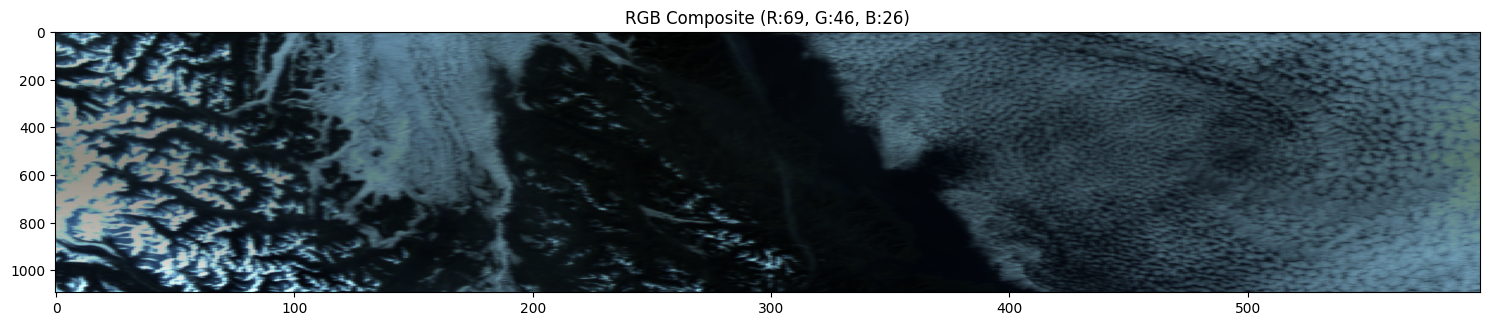

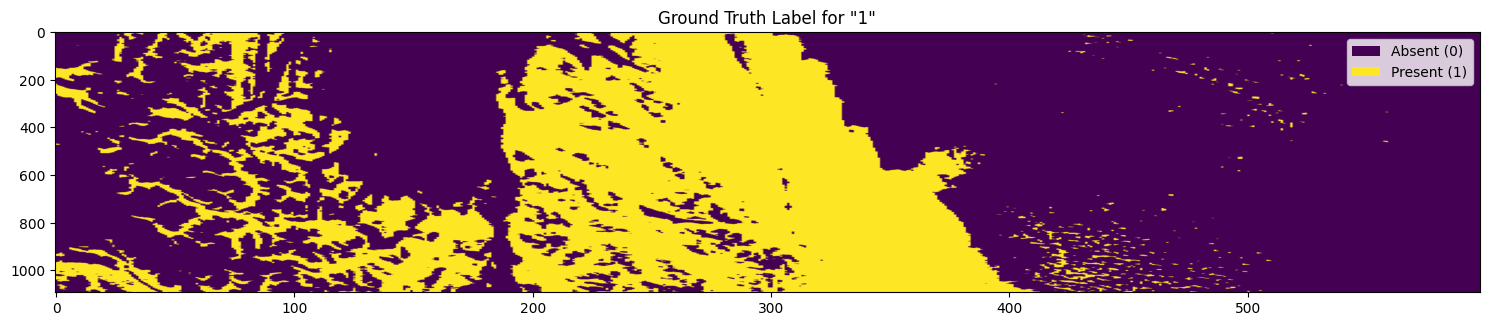

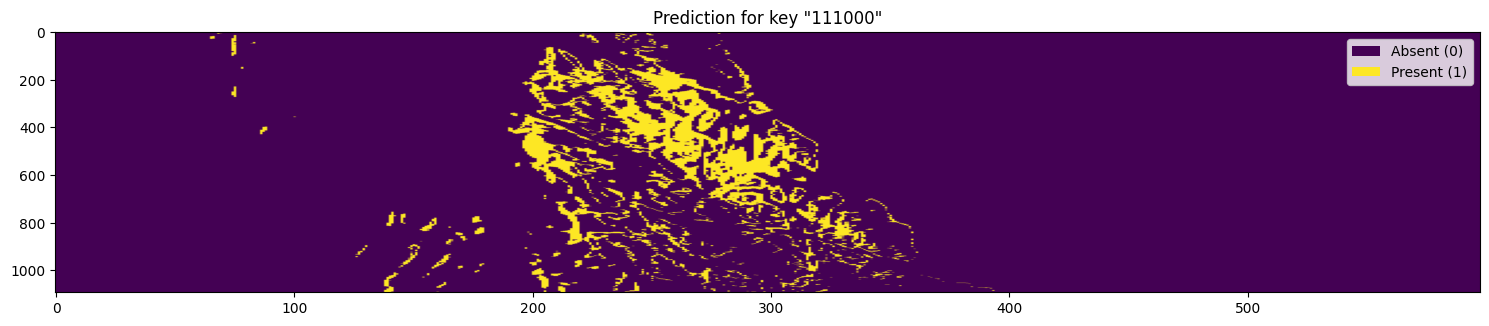

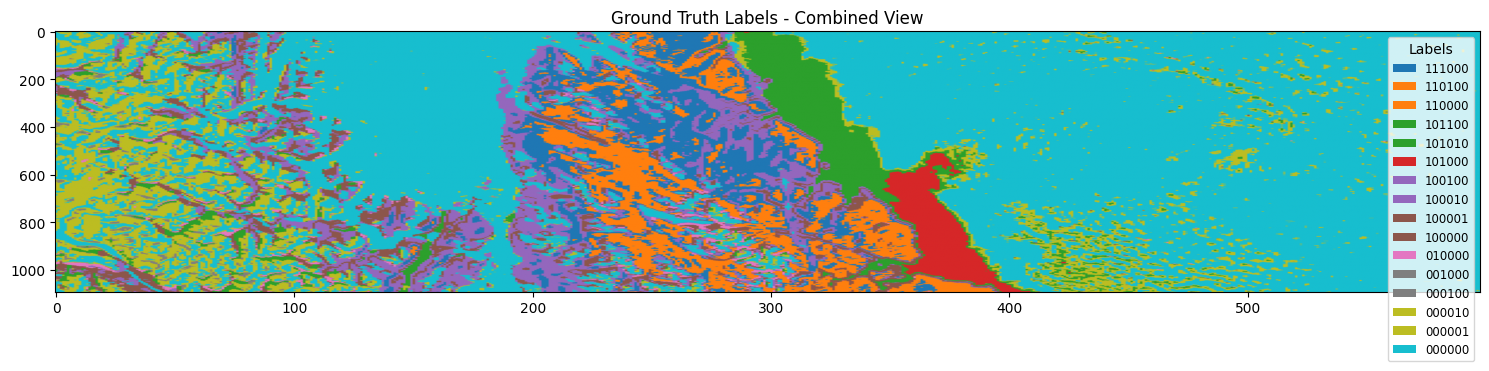

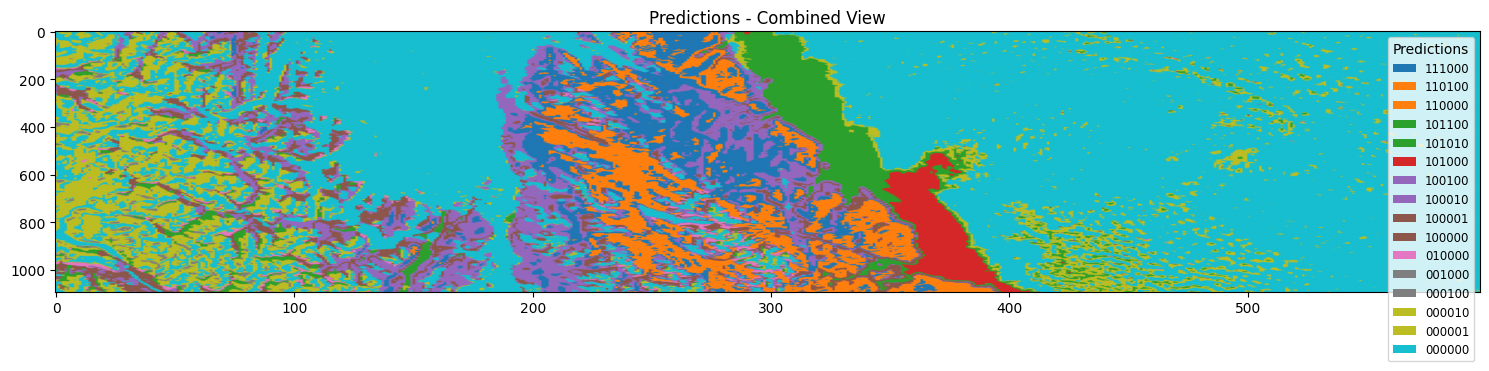

In [8]:
tree.plot_input_image(catala_rad_cube)
tree.plot_ground_truth(catala_labels, key='1')  
tree.plot_prediction(prediction, key='111000')  
tree.plot_ground_truth(catala_labels)
tree.plot_prediction(prediction)

In [9]:
tree.save_model_parameters()

Preparing to save model parameters...
Node  SVM weights shape: (1, 112)
Node  SVM weights: [[10.06889059  7.91189379  6.51453945  5.05728174  4.40095775  2.41204151
   2.87730369  1.03443347  0.72277135 -0.68053069 -0.8570739  -1.81315002
  -1.99311669 -2.39865836 -2.67438217 -2.91622153 -2.746061   -2.91180724
  -2.86674335 -2.84897178 -3.12585977 -3.42684795 -3.03725457 -3.15727153
  -3.19331649 -3.25918201 -2.96631901 -2.98320768 -3.01231333 -3.11948036
  -3.05456205 -2.89120778 -3.03204062 -2.90829074 -2.85518178 -2.87463268
  -2.82928226 -2.80405458 -2.82835353 -2.80366822 -2.83755818 -2.87013177
  -3.03031094 -3.01627035 -3.06248639 -3.12127905 -3.18187822 -3.21344122
  -3.37107117 -3.62763542 -3.83791102 -3.91175249 -3.98111855 -4.15252103
  -4.43934588 -4.61058067 -4.7484672  -4.96389533 -5.21880615 -5.43225368
  -5.66641963 -5.83624066 -5.73095714 -5.92440333 -6.30835344 -6.67039319
  -7.00816436 -7.21993832 -7.45772744 -7.81038536 -8.1196077  -8.24837726
  -8.73791912 -9.0122